In [1]:
from IPython.display import display, HTML
display(HTML("""
<style>
div.container{width:85% !important;}
div.cell.code_cell.rendered{width:100%;}
div.input_prompt{padding:0px;}
div.CodeMirror {font-family:Consolas; font-size:12pt;}
div.output {font-size:12pt; font-weight:bold;}
div.input {font-family:Consolas; font-size:12pt;}
div.prompt {min-width:70px;}
div#toc-wrapper{padding-top:120px;}
div.text_cell_render ul li{font-size:12pt;padding:5px;}
table.dataframe{font-size:12px;}
</style>
"""))

# red wine 품질 등급 예측

```
1. 데이터셋 확보 & 전처리
    독립변수와 타겟변수 분리 :
    -> 독립변수만 스케일 조정(StandardScaler) 
    -> 타겟변수 one-hot-encoding(get_dummies) 
    -> 훈련셋과 테스트셋 분리(train_test_split)
2. 모델 구성(입력(독립)변수 11, 출력(종속)변수 ? -> one-hot-encoding 필요
3. 모델 학습 과정 설정(다중분류로 설정) -> 출력층의 활성화함수 : softmax
4. 모델 학습(callbacks 이용)
5. 모델 평가 - 그래프, 평가(테스트셋), 교차표/혼동행렬
6. 모델 저장 및 사용
```

In [2]:
import numpy as np
import pandas as pd # read_csv, get_dummies, crosstab
from sklearn.preprocessing import StandardScaler, MinMaxScaler
from sklearn.model_selection import train_test_split
from tensorflow.keras.models import Sequential, save_model, load_model
from tensorflow.keras.layers import Input, Dense, Dropout, LeakyReLU
from tensorflow.keras.metrics import Recall, Precision # compile 단계에서 사용
from tensorflow.keras.callbacks import EarlyStopping, Callback, ModelCheckpoint
import matplotlib.pyplot as plt

# 1. 데이터셋 확보 & 전처리
- 독립변수와 타겟변수 분리 :
    * 독립변수만 스케일 조정(StandardScaler) 
    * 타겟변수 one-hot-encoding(get_dummies) 
    * 훈련셋과 테스트셋 분리(train_test_split)

In [3]:
# 데이터 읽어오기
# # data = np.loadtxt('data/winequality-red.csv', delimiter=';', skiprows=1)
# np.genfromtxt('data/winequality-red.csv', delimiter=';', skip_header=1)
redwine = pd.read_csv('data/winequality-red.csv', delimiter=';') # 결측치가 있을 경우를 대비해 df로 불러오기
redwine.head()
# 독립변수 :
# 고정 산도(fixed acidity)
# 휘발성 산도(volatile acidity)
# 구연산(citric acid)
# 잔여 당분(residual sugar)
# 염화물(chlorides)
# 유리 아황산염(free sulfur dioxide)
# 총 아황산염(total sulfur dioxide)
# 밀도(density)
# pH
# 황산염(sulphates)
# 알코올(alcohol)

# 타겟변수 :
# 품질 등급(quality)

,fixed acidity,volatile acidity,citric acid,residual sugar,chlorides,free sulfur dioxide,total sulfur dioxide,density,pH,sulphates,alcohol,quality
0,7.4,0.70,0.00,1.9,0.076,11.0,34.0,0.9978,3.51,0.56,9.4,5
1,7.8,0.88,0.00,2.6,0.098,25.0,67.0,0.9968,3.20,0.68,9.8,5
2,7.8,0.76,0.04,2.3,0.092,15.0,54.0,0.9970,3.26,0.65,9.8,5
3,11.2,0.28,0.56,1.9,0.075,17.0,60.0,0.9980,3.16,0.58,9.8,6
4,7.4,0.70,0.00,1.9,0.076,11.0,34.0,0.9978,3.51,0.56,9.4,5


In [4]:
redwine.info() # 결측치 없음

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1599 entries, 0 to 1598
Data columns (total 12 columns):
 #   Column                Non-Null Count  Dtype  
---  ------                --------------  -----  
 0   fixed acidity         1599 non-null   float64
 1   volatile acidity      1599 non-null   float64
 2   citric acid           1599 non-null   float64
 3   residual sugar        1599 non-null   float64
 4   chlorides             1599 non-null   float64
 5   free sulfur dioxide   1599 non-null   float64
 6   total sulfur dioxide  1599 non-null   float64
 7   density               1599 non-null   float64
 8   pH                    1599 non-null   float64
 9   sulphates             1599 non-null   float64
 10  alcohol               1599 non-null   float64
 11  quality               1599 non-null   int64  
dtypes: float64(11), int64(1)
memory usage: 150.0 KB


In [5]:
# 타겟변수의 균형
# redwine.quality.value_counts() / len(redwine) * 100 
redwine.quality.value_counts(normalize=True) * 100

5    42.589118
6    39.899937
7    12.445278
4     3.314572
8     1.125704
3     0.625391
Name: quality, dtype: float64

In [6]:
# 독립변수, 타겟변수 분리
X_redwine = redwine.iloc[:, :-1].values # to_numpy와 유사. numpy 배열로
y_redwine = redwine.iloc[:, -1] # 3, 4, 5, 6, 7, 8 등급

In [7]:
X_redwine.shape

(1599, 11)

In [8]:
# 독립변수 X의 스케일 조정
scaler = StandardScaler()
scaled_X_redwine = scaler.fit_transform(X_redwine)
# 다중분류를 위한 타겟변수의 one-hot-encoding -> numpy 배열로 변환
Y_redwine = pd.get_dummies(y_redwine).to_numpy()

In [10]:
scaled_X_redwine[:1]

array([[-0.52835961,  0.96187667, -1.39147228, -0.45321841, -0.24370669,
        -0.46619252, -0.37913269,  0.55827446,  1.28864292, -0.57920652,
        -0.96024611]])

In [14]:
print('원래 데이터\t원핫인코딩')
# 원핫인코딩한 0번째 인덱스가 3등급(get_dummies()사용했기 때문)
np.column_stack((y_redwine[3:5], Y_redwine[3:5]))

원래 데이터	원핫인코딩


array([[6, 0, 0, 0, 1, 0, 0],
       [5, 0, 0, 1, 0, 0, 0]], dtype=int64)

In [12]:
Y_redwine

array([[0, 0, 1, 0, 0, 0],
       [0, 0, 1, 0, 0, 0],
       [0, 0, 1, 0, 0, 0],
       ...,
       [0, 0, 0, 1, 0, 0],
       [0, 0, 1, 0, 0, 0],
       [0, 0, 0, 1, 0, 0]], dtype=uint8)

In [9]:
# 독립변수 & 타겟변수
scaled_X_redwine.shape, Y_redwine.shape

((1599, 11), (1599, 6))

In [15]:
# 훈련셋과 테스트셋 분리(층화추출)
X_train, X_test, Y_train, Y_test = train_test_split(scaled_X_redwine,
                                                    Y_redwine,
#                                                   test_size=0.3,
                                                    train_size=0.7,
                                                    stratify=Y_redwine
#                                                     random_state=12
                                                   )
X_train.shape, Y_train.shape, X_test.shape, Y_test.shape

((1119, 11), (1119, 6), (480, 11), (480, 6))

In [17]:
pd.Series(Y_redwine.argmax(axis=1)).value_counts(normalize=True) * 100
pd.Series(Y_train.argmax(axis=1)).value_counts(normalize=True) * 100
pd.Series(Y_test.argmax(axis=1)).value_counts(normalize=True) * 100

2    42.500000
3    40.000000
4    12.500000
1     3.333333
5     1.041667
0     0.625000
dtype: float64

In [18]:
np.c_[pd.Series(Y_redwine.argmax(axis=1)).value_counts(normalize=True) * 100,
      pd.Series(Y_train.argmax(axis=1)).value_counts(normalize=True) * 100,
      pd.Series(Y_test.argmax(axis=1)).value_counts(normalize=True) * 100]

array([[42.5891182 , 42.62734584, 42.5       ],
       [39.89993746, 39.85701519, 40.        ],
       [12.4452783 , 12.42180518, 12.5       ],
       [ 3.31457161,  3.30652368,  3.33333333],
       [ 1.12570356,  1.16175156,  1.04166667],
       [ 0.62539087,  0.62555853,  0.625     ]])

# 2. 모델 구성(입력 11, 출력 6)

In [19]:
model = Sequential()
model.add(Input(11))
model.add(Dense(units=50, activation='relu'))
model.add(Dense(units=50, activation='relu'))
model.add(Dropout(0.1))
model.add(Dense(30, 'relu'))
model.add(Dense(6, activation='softmax'))
model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 dense (Dense)               (None, 50)                600       
                                                                 
 dense_1 (Dense)             (None, 50)                2550      
                                                                 
 dropout (Dropout)           (None, 50)                0         
                                                                 
 dense_2 (Dense)             (None, 30)                1530      
                                                                 
 dense_3 (Dense)             (None, 6)                 186       
                                                                 
Total params: 4,866
Trainable params: 4,866
Non-trainable params: 0
_________________________________________________________________


# 3. 모델 학습 과정  설정(다중 분류에 맞는 설정)

# 4. 학습시키기(callbacks 사용)

In [27]:
%%time
model.compile(loss='categorical_crossentropy',
             optimizer='adam',
             metrics=['accuracy'])
# on_epoch_end()함수가 epoch 수행 후 자동 호춣
class CustomHistory(Callback): # class 조회 : anaconda prompt / vscode 
    def __init__(self): # 생성자 함수
        self.epoch = 0
    def on_epoch_end(self, batch, logs={}):
        '1epoch마다 자동 실행되는 함수'
        self.epoch += 1
        if self.epoch % 10 == 0:
            print('epoch : {}, loss : {:.4f}, acc : {:.4f}, val_loss : {:.4f}, val_acc : {:.4f}'\
                  .format(self.epoch,
                          logs.get('loss'),
                          logs.get('accuracy', '-'),
                          logs.get('val_loss', '-'),
                          logs.get('val_accuracy', '-')
            ))
model_save_folder = './model/'
import os
if not os.path.exists(model_save_folder):
    os.mkdir(model_save_folder)
file = model_save_folder + 'wine-{epoch:03d}-loss{val_loss:.4f}-acc{val_accuracy:.4f}.h5'
customHistory = CustomHistory()
checkpoint = ModelCheckpoint(
                    filepath=file,
                    monitor='val_accuracy', # 모니터링 지표 : loss, val_loss, accuracy
                    save_best_only=True,
                    mode='max',
                    verbose=0) # log 출력 여부
earlyStopping = EarlyStopping(monitor='val_loss', patience=20)
# 학습
hist = model.fit(X_train, Y_train, epochs=100, batch_size=200,
                validation_split=0.2, # 학습셋의 20%는 검증셋으로
                verbose=0, # log 출력 막음(callback 함수에서 출력)
                callbacks=[earlyStopping, customHistory, checkpoint])

epoch : 10, loss : 0.6859, acc : 0.7274, val_loss : 0.9353, val_acc : 0.6339
epoch : 20, loss : 0.6643, acc : 0.7363, val_loss : 0.9434, val_acc : 0.6384
CPU times: total: 1.31 s
Wall time: 1.17 s


# 5. 모델 평가
- 학습 과정 시각화, 평가(테스트셋), 교차표(혼동행렬)

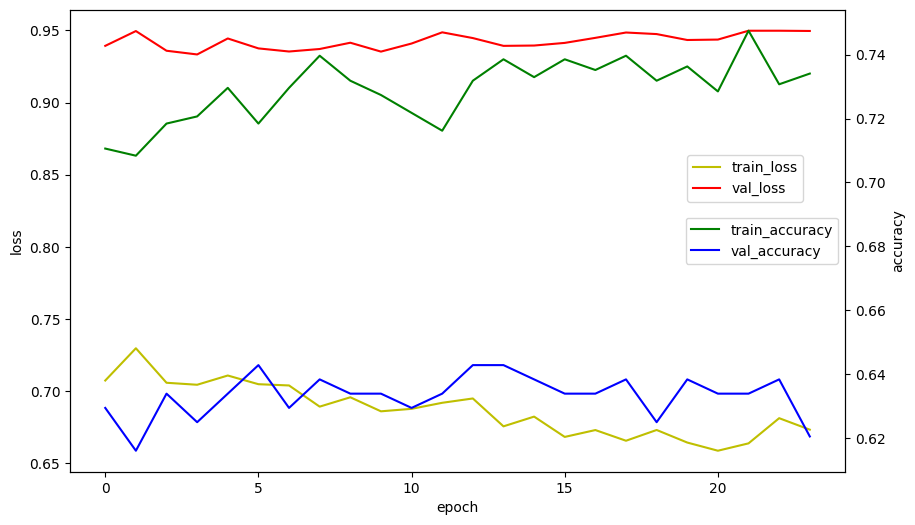

In [28]:
# 학습과정 표시하기
import matplotlib.pyplot as plt
fig, loss_ax = plt.subplots(figsize=(10,6))
loss_ax.plot(hist.history['loss'], 'y', label='train_loss')
loss_ax.plot(hist.history['val_loss'], 'r', label='val_loss')
acc_ax = loss_ax.twinx() # loss_ax와 x축을 공유하는 acc_ax 생성
acc_ax.plot(hist.history['accuracy'], 'g', label='train_accuracy')
acc_ax.plot(hist.history['val_accuracy'], 'b', label='val_accuracy')
loss_ax.set_xlabel('epoch')
loss_ax.set_ylabel('loss')
acc_ax.set_ylabel('accuracy')
loss_ax.legend(bbox_to_anchor=(0.955, 0.7))
acc_ax.legend(loc='center right')
plt.show()

In [31]:
# 모델 평가(테스트셋으로)
loss_and_acc = model.evaluate(X_test, Y_test, batch_size=100, verbose=0)
print('loss :', loss_and_acc[0]) # loss_metrics의 구조는 학습 과정 설정 단계인 compile 단계의 매개변수를 참조
print('accuracy :', loss_and_acc[1])

loss : 1.0288922786712646
accuracy : 0.6270833611488342


In [33]:
model1 = load_model('model/wine-043-loss0.9177-acc0.6384.h5')
loss_and_acc1 = model1.evaluate(X_test, Y_test, batch_size=100, verbose=0)
print('loss :', loss_and_acc1[0]) # loss_metrics의 구조는 학습 과정 설정 단계인 compile 단계의 매개변수를 참조
print('accuracy :', loss_and_acc1[1])

loss : 0.9510709643363953
accuracy : 0.6104166507720947


In [34]:
model.save('model/wine.h5')

In [44]:
# 교차표 (실제값과 예측값을 1차원 데이터로)
real = Y_test.argmax(axis=1) +3 # 실제값
# real = np.argmax(Y_test, axis=1)
real

array([5, 8, 5, 5, 5, 5, 6, 6, 7, 7, 6, 7, 5, 5, 6, 5, 6, 5, 7, 6, 6, 5,
       5, 4, 5, 5, 6, 8, 6, 6, 6, 6, 4, 6, 4, 4, 6, 5, 5, 5, 5, 6, 5, 5,
       6, 7, 6, 5, 6, 6, 6, 6, 3, 7, 5, 6, 6, 6, 5, 4, 7, 7, 5, 7, 5, 6,
       6, 7, 6, 5, 5, 6, 5, 6, 7, 6, 7, 5, 7, 5, 5, 6, 6, 5, 6, 6, 6, 5,
       6, 5, 7, 6, 6, 7, 5, 6, 3, 6, 6, 6, 5, 5, 5, 6, 5, 6, 7, 6, 5, 6,
       7, 3, 5, 6, 5, 5, 7, 5, 5, 5, 5, 5, 5, 5, 7, 5, 6, 6, 5, 5, 5, 5,
       5, 7, 6, 5, 6, 5, 6, 5, 5, 5, 4, 5, 6, 5, 5, 5, 5, 6, 5, 6, 7, 6,
       5, 7, 6, 5, 5, 6, 6, 6, 6, 7, 4, 5, 5, 6, 7, 6, 6, 6, 6, 6, 6, 6,
       6, 4, 6, 5, 6, 7, 6, 5, 6, 7, 5, 5, 5, 6, 5, 5, 5, 6, 6, 5, 5, 6,
       5, 6, 5, 6, 6, 6, 5, 5, 6, 5, 5, 5, 6, 6, 5, 6, 5, 5, 5, 6, 6, 5,
       5, 6, 7, 6, 7, 6, 5, 6, 6, 4, 5, 5, 5, 7, 5, 7, 5, 6, 6, 7, 6, 6,
       5, 6, 5, 5, 6, 6, 5, 6, 7, 7, 5, 5, 6, 6, 5, 5, 5, 7, 5, 6, 5, 5,
       5, 6, 7, 6, 6, 6, 6, 5, 8, 5, 7, 5, 5, 7, 7, 6, 6, 6, 5, 6, 5, 6,
       6, 5, 6, 5, 6, 4, 6, 5, 5, 5, 6, 5, 6, 6, 6,

In [45]:
pred = model.predict(X_test).argmax(axis=1) + 3
# pred = np.argmax(model.predict(X_test), axis=1)
pred

15/15 [==============================] - 0s 858us/step


array([5, 7, 5, 5, 5, 5, 7, 7, 6, 6, 6, 7, 5, 5, 5, 5, 6, 5, 6, 6, 6, 5,
       6, 5, 5, 5, 6, 6, 6, 6, 5, 5, 5, 6, 5, 5, 5, 6, 5, 5, 5, 5, 5, 6,
       7, 7, 5, 5, 6, 5, 6, 6, 5, 7, 5, 5, 6, 6, 6, 5, 6, 6, 5, 6, 5, 6,
       6, 6, 6, 5, 6, 6, 6, 6, 7, 6, 7, 6, 6, 5, 5, 5, 6, 5, 6, 5, 6, 5,
       5, 5, 6, 6, 5, 6, 5, 5, 5, 6, 7, 6, 5, 5, 6, 6, 5, 7, 7, 6, 6, 5,
       7, 6, 6, 6, 5, 5, 6, 6, 6, 5, 6, 5, 5, 6, 6, 5, 6, 5, 5, 5, 5, 6,
       5, 6, 5, 5, 6, 5, 5, 5, 5, 5, 5, 5, 6, 5, 5, 5, 5, 5, 5, 6, 6, 5,
       5, 6, 5, 5, 5, 5, 6, 6, 5, 7, 5, 5, 5, 6, 6, 6, 6, 6, 6, 6, 5, 6,
       6, 5, 6, 5, 7, 6, 5, 5, 6, 6, 5, 6, 5, 5, 5, 5, 5, 7, 6, 5, 6, 6,
       5, 6, 5, 6, 5, 6, 5, 5, 5, 5, 5, 5, 6, 5, 5, 6, 5, 5, 5, 5, 7, 6,
       5, 6, 7, 6, 6, 6, 5, 6, 6, 5, 5, 5, 5, 7, 5, 6, 5, 6, 5, 6, 6, 6,
       5, 6, 5, 5, 6, 5, 5, 6, 6, 5, 5, 5, 7, 6, 5, 6, 6, 7, 5, 5, 5, 5,
       5, 5, 7, 6, 6, 6, 5, 5, 7, 5, 6, 5, 5, 7, 6, 6, 6, 7, 5, 6, 5, 5,
       6, 5, 6, 6, 5, 6, 5, 6, 6, 5, 6, 5, 5, 5, 6,

In [46]:
pd.crosstab(real, pred, rownames=['real'], colnames=['predict'])

predict,5,6,7
real,,,
3,2,1,0
4,13,3,0
5,162,42,0
6,61,118,13
7,3,36,21
8,0,2,3


# 6. 모델 사용

In [49]:
X_redwine[0]

array([ 7.4   ,  0.7   ,  0.    ,  1.9   ,  0.076 , 11.    , 34.    ,
        0.9978,  3.51  ,  0.56  ,  9.4   ])

In [51]:
input_data = [[7.4  ,  0.7  ,  0,  1.9,  0.076, 11.0, 34.0,
        0.9978,  3.51,  0.56,  9.4]] # 반드시 2차원으로!
scaled_data = scaler.transform(input_data)
model.predict(scaled_data)

1/1 [==============================] - 0s 48ms/step


array([[3.3680247e-03, 4.5144081e-02, 8.5512853e-01, 9.5841527e-02,
        4.9430446e-04, 2.3537819e-05]], dtype=float32)

In [53]:
model.predict(scaled_data).argmax(axis=1)+3

1/1 [==============================] - 0s 16ms/step


array([5], dtype=int64)